# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import ast
from wordcloud import WordCloud


# Load the dataset

In [2]:
movies=pd.read_csv('tmdb_5000_movies.csv')
credits=pd.read_csv('tmdb_5000_credits.csv')

In [3]:
movies.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


In [4]:
credits.head(1)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


In [5]:
movies=movies.merge(credits,on='title')

In [6]:
movies.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


# Data preprocessing

In [7]:
# Important columns:
# genres
# id
# keywords
# title
# overview
# cast
# crew
movies=movies[['movie_id','title','overview','genres','keywords','cast','crew']]

In [8]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  4809 non-null   int64 
 1   title     4809 non-null   object
 2   overview  4806 non-null   object
 3   genres    4809 non-null   object
 4   keywords  4809 non-null   object
 5   cast      4809 non-null   object
 6   crew      4809 non-null   object
dtypes: int64(1), object(6)
memory usage: 263.1+ KB


In [9]:
movies.head()

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...","[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"John Carter is a war-weary, former military ca...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":...","[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [10]:
movies.isnull().sum()

movie_id    0
title       0
overview    3
genres      0
keywords    0
cast        0
crew        0
dtype: int64

In [11]:
movies.dropna(inplace=True)

In [12]:
movies.duplicated().sum()

np.int64(0)

In [13]:
movies.iloc[0].genres

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

In [14]:
def convert(obj):
    L=[]
    for i in ast.literal_eval(obj):#string to list converted so that loop can run now
        L.append(i['name'])
    return L


In [15]:
movies['genres']=movies['genres'].apply(convert)

In [16]:
movies['keywords']=movies['keywords'].apply(convert)

In [17]:
movies.head()

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...,"[Action, Crime, Drama, Thriller]","[dc comics, crime fighter, terrorist, secret i...","[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"John Carter is a war-weary, former military ca...","[Action, Adventure, Science Fiction]","[based on novel, mars, medallion, space travel...","[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [18]:
#for info in cast
def convertagain(obj):
    L=[]
    c=0
    for i in ast.literal_eval(obj):#string to list converted so that loop can run now
        if c!=3:
            L.append(i['name'])
            c+=1
        else:
            break
    return L

In [19]:
movies['cast']=movies['cast'].apply(convertagain)#extracted first three names of actors only

In [20]:
movies.head()

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weaver]","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Johnny Depp, Orlando Bloom, Keira Knightley]","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[Daniel Craig, Christoph Waltz, Léa Seydoux]","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...,"[Action, Crime, Drama, Thriller]","[dc comics, crime fighter, terrorist, secret i...","[Christian Bale, Michael Caine, Gary Oldman]","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"John Carter is a war-weary, former military ca...","[Action, Adventure, Science Fiction]","[based on novel, mars, medallion, space travel...","[Taylor Kitsch, Lynn Collins, Samantha Morton]","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [21]:
movies['crew'][0]

'[{"credit_id": "52fe48009251416c750aca23", "department": "Editing", "gender": 0, "id": 1721, "job": "Editor", "name": "Stephen E. Rivkin"}, {"credit_id": "539c47ecc3a36810e3001f87", "department": "Art", "gender": 2, "id": 496, "job": "Production Design", "name": "Rick Carter"}, {"credit_id": "54491c89c3a3680fb4001cf7", "department": "Sound", "gender": 0, "id": 900, "job": "Sound Designer", "name": "Christopher Boyes"}, {"credit_id": "54491cb70e0a267480001bd0", "department": "Sound", "gender": 0, "id": 900, "job": "Supervising Sound Editor", "name": "Christopher Boyes"}, {"credit_id": "539c4a4cc3a36810c9002101", "department": "Production", "gender": 1, "id": 1262, "job": "Casting", "name": "Mali Finn"}, {"credit_id": "5544ee3b925141499f0008fc", "department": "Sound", "gender": 2, "id": 1729, "job": "Original Music Composer", "name": "James Horner"}, {"credit_id": "52fe48009251416c750ac9c3", "department": "Directing", "gender": 2, "id": 2710, "job": "Director", "name": "James Cameron"},

In [22]:
def fetch_director(obj):
    L=[]
    for i in ast.literal_eval(obj):#string to list converted so that loop can run now
        if i['job']=='Director':
            L.append(i['name'])
            break
    return L

In [23]:
movies['crew']=movies['crew'].apply(fetch_director)

In [24]:
movies.head()

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weaver]",[James Cameron]
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Johnny Depp, Orlando Bloom, Keira Knightley]",[Gore Verbinski]
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[Daniel Craig, Christoph Waltz, Léa Seydoux]",[Sam Mendes]
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...,"[Action, Crime, Drama, Thriller]","[dc comics, crime fighter, terrorist, secret i...","[Christian Bale, Michael Caine, Gary Oldman]",[Christopher Nolan]
4,49529,John Carter,"John Carter is a war-weary, former military ca...","[Action, Adventure, Science Fiction]","[based on novel, mars, medallion, space travel...","[Taylor Kitsch, Lynn Collins, Samantha Morton]",[Andrew Stanton]


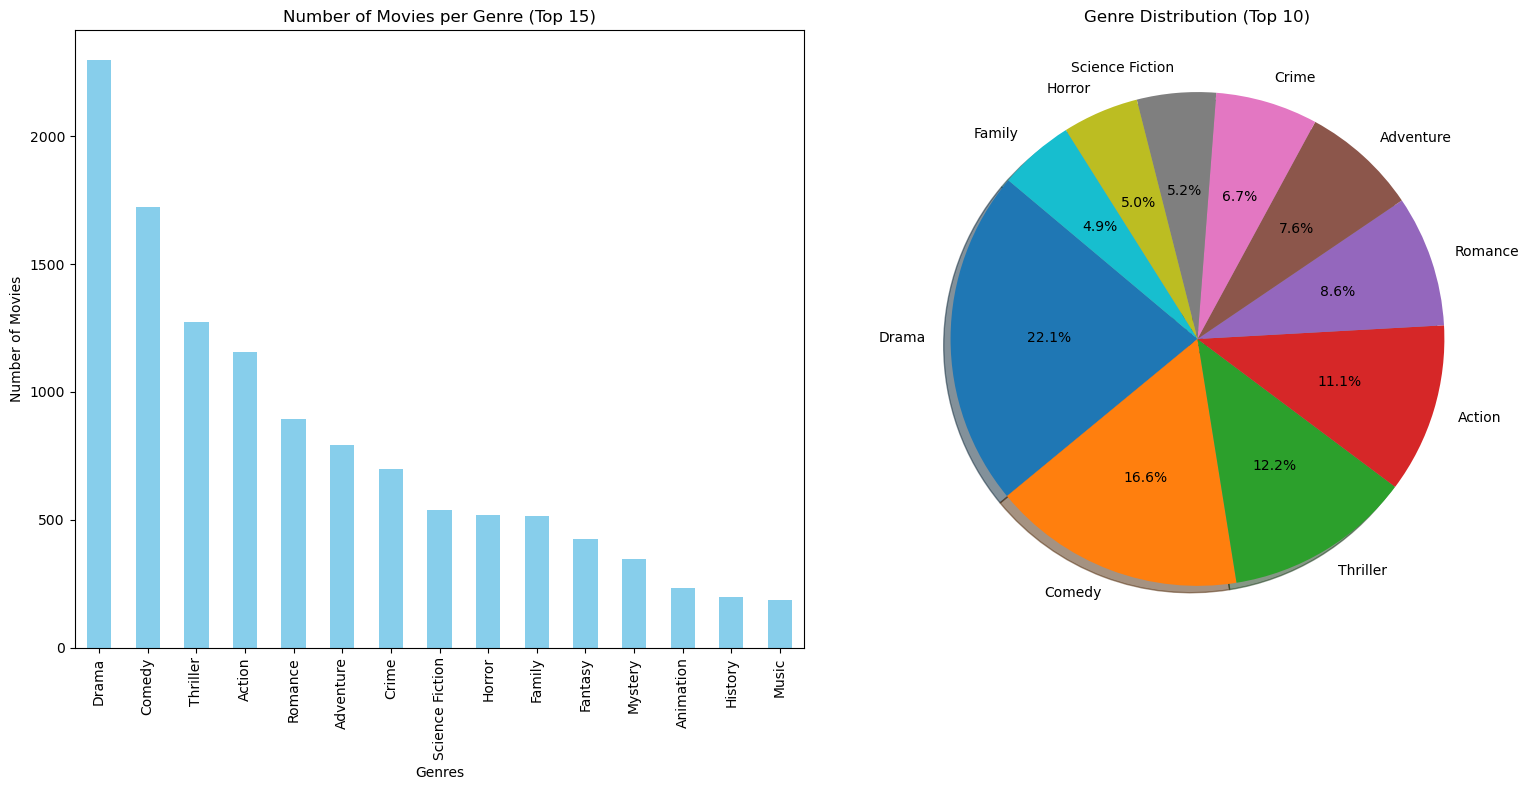

In [25]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # 1 row, 2 columns

# Count number of movies per genre
genre_counts = movies.explode('genres')['genres'].value_counts()

# Bar chart
genre_counts.head(15).plot(kind='bar', color='skyblue', ax=axes[0])
axes[0].set_title("Number of Movies per Genre (Top 15)")
axes[0].set_xlabel("Genres")
axes[0].set_ylabel("Number of Movies")

# Pie chart
genre_counts.head(10).plot(kind='pie', autopct='%1.1f%%', startangle=140, shadow=True, ax=axes[1])
axes[1].set_title("Genre Distribution (Top 10)")
axes[1].set_ylabel("")  # remove ylabel for pie

plt.tight_layout()
plt.show()


In [26]:
movies['overview'][0] #its a string

'In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.'

In [27]:
movies['overview'] = movies['overview'].apply(lambda x:x.split()) #convert from string to list

In [28]:
movies.head()

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weaver]",[James Cameron]
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Johnny Depp, Orlando Bloom, Keira Knightley]",[Gore Verbinski]
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send...","[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[Daniel Craig, Christoph Waltz, Léa Seydoux]",[Sam Mendes]
3,49026,The Dark Knight Rises,"[Following, the, death, of, District, Attorney...","[Action, Crime, Drama, Thriller]","[dc comics, crime fighter, terrorist, secret i...","[Christian Bale, Michael Caine, Gary Oldman]",[Christopher Nolan]
4,49529,John Carter,"[John, Carter, is, a, war-weary,, former, mili...","[Action, Adventure, Science Fiction]","[based on novel, mars, medallion, space travel...","[Taylor Kitsch, Lynn Collins, Samantha Morton]",[Andrew Stanton]


In [29]:
#now remove space between words
movies['genres'] = movies['genres'].apply(lambda x:[i.replace(" ","") for i in x])
movies['keywords'] = movies['keywords'].apply(lambda x:[i.replace(" ","") for i in x])
movies['cast'] = movies['cast'].apply(lambda x:[i.replace(" ","") for i in x])
movies['crew'] = movies['crew'].apply(lambda x:[i.replace(" ","") for i in x])

In [30]:
movies.head()

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[Action, Adventure, Fantasy, ScienceFiction]","[cultureclash, future, spacewar, spacecolony, ...","[SamWorthington, ZoeSaldana, SigourneyWeaver]",[JamesCameron]
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d...","[Adventure, Fantasy, Action]","[ocean, drugabuse, exoticisland, eastindiatrad...","[JohnnyDepp, OrlandoBloom, KeiraKnightley]",[GoreVerbinski]
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send...","[Action, Adventure, Crime]","[spy, basedonnovel, secretagent, sequel, mi6, ...","[DanielCraig, ChristophWaltz, LéaSeydoux]",[SamMendes]
3,49026,The Dark Knight Rises,"[Following, the, death, of, District, Attorney...","[Action, Crime, Drama, Thriller]","[dccomics, crimefighter, terrorist, secretiden...","[ChristianBale, MichaelCaine, GaryOldman]",[ChristopherNolan]
4,49529,John Carter,"[John, Carter, is, a, war-weary,, former, mili...","[Action, Adventure, ScienceFiction]","[basedonnovel, mars, medallion, spacetravel, p...","[TaylorKitsch, LynnCollins, SamanthaMorton]",[AndrewStanton]


In [31]:
movies['tags']= movies['overview'] + movies['genres'] + movies['keywords'] + movies['cast'] + movies['crew'] 

In [32]:
movies.head()

,movie_id,title,overview,genres,keywords,cast,crew,tags
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[Action, Adventure, Fantasy, ScienceFiction]","[cultureclash, future, spacewar, spacecolony, ...","[SamWorthington, ZoeSaldana, SigourneyWeaver]",[JamesCameron],"[In, the, 22nd, century,, a, paraplegic, Marin..."
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d...","[Adventure, Fantasy, Action]","[ocean, drugabuse, exoticisland, eastindiatrad...","[JohnnyDepp, OrlandoBloom, KeiraKnightley]",[GoreVerbinski],"[Captain, Barbossa,, long, believed, to, be, d..."
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send...","[Action, Adventure, Crime]","[spy, basedonnovel, secretagent, sequel, mi6, ...","[DanielCraig, ChristophWaltz, LéaSeydoux]",[SamMendes],"[A, cryptic, message, from, Bond’s, past, send..."
3,49026,The Dark Knight Rises,"[Following, the, death, of, District, Attorney...","[Action, Crime, Drama, Thriller]","[dccomics, crimefighter, terrorist, secretiden...","[ChristianBale, MichaelCaine, GaryOldman]",[ChristopherNolan],"[Following, the, death, of, District, Attorney..."
4,49529,John Carter,"[John, Carter, is, a, war-weary,, former, mili...","[Action, Adventure, ScienceFiction]","[basedonnovel, mars, medallion, spacetravel, p...","[TaylorKitsch, LynnCollins, SamanthaMorton]",[AndrewStanton],"[John, Carter, is, a, war-weary,, former, mili..."


In [33]:
new_df= movies[['movie_id','title','tags']]

In [34]:
new_df

,movie_id,title,tags
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin..."
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d..."
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send..."
3,49026,The Dark Knight Rises,"[Following, the, death, of, District, Attorney..."
4,49529,John Carter,"[John, Carter, is, a, war-weary,, former, mili..."
...,...,...,...
4804,9367,El Mariachi,"[El, Mariachi, just, wants, to, play, his, gui..."
4805,72766,Newlyweds,"[A, newlywed, couple's, honeymoon, is, upended..."
4806,231617,"Signed, Sealed, Delivered","[""Signed,, Sealed,, Delivered"", introduces, a,..."
4807,126186,Shanghai Calling,"[When, ambitious, New, York, attorney, Sam, is..."


In [35]:
new_df['tags']=new_df['tags'].apply(lambda x:" ".join(x))

C:\Users\Biproteep\AppData\Local\Temp\ipykernel_21428\487797088.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags']=new_df['tags'].apply(lambda x:" ".join(x))


In [36]:
new_df['tags'][0]

'In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization. Action Adventure Fantasy ScienceFiction cultureclash future spacewar spacecolony society spacetravel futuristic romance space alien tribe alienplanet cgi marine soldier battle loveaffair antiwar powerrelations mindandsoul 3d SamWorthington ZoeSaldana SigourneyWeaver JamesCameron'

In [37]:
new_df['tags']=new_df['tags'].apply(lambda x:x.lower())

C:\Users\Biproteep\AppData\Local\Temp\ipykernel_21428\4224080999.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags']=new_df['tags'].apply(lambda x:x.lower())


In [38]:
new_df.head()

,movie_id,title,tags
0,19995,Avatar,"in the 22nd century, a paraplegic marine is di..."
1,285,Pirates of the Caribbean: At World's End,"captain barbossa, long believed to be dead, ha..."
2,206647,Spectre,a cryptic message from bond’s past sends him o...
3,49026,The Dark Knight Rises,following the death of district attorney harve...
4,49529,John Carter,"john carter is a war-weary, former military ca..."


# Most Common Words in Tags

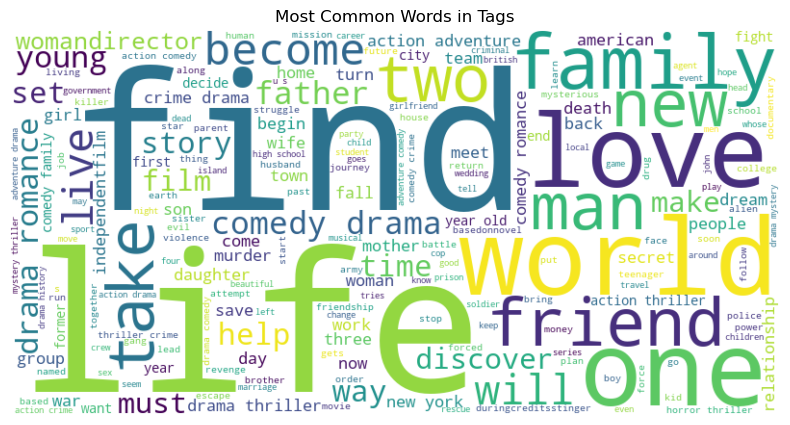

In [39]:
combined_text = " ".join(new_df['tags'])

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(combined_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Tags")
plt.show()

In [40]:
import nltk

In [41]:
from nltk.stem.porter import PorterStemmer
ps=PorterStemmer()

In [42]:
def stem(text):
    list=[]
    for i in text.split():
        list.append(ps.stem(i))
    return " ".join(list)

In [43]:
new_df['tags']=new_df['tags'].apply(stem)

C:\Users\Biproteep\AppData\Local\Temp\ipykernel_21428\3514595201.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags']=new_df['tags'].apply(stem)


# Approach 1 (Basic) : BoW (Bag of Words)

In [44]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(max_features=5000,stop_words='english')

In [45]:
vectors= cv.fit_transform(new_df['tags']).toarray() # converted wrods to vector

In [46]:
vectors

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [47]:
len(cv.get_feature_names_out())

5000

In [48]:
cv.get_feature_names_out()

array(['000', '007', '10', ..., 'zone', 'zoo', 'zooeydeschanel'],
      dtype=object)

In [49]:
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(vectors)

In [50]:
# sorting on the basis of 2nd value which is similarity and not the index created until 5 numbers
sorted(list(enumerate(similarity[0])),reverse=True,key=lambda x:x[1])[1:6] 

[(1214, np.float64(0.28676966733820225)),
 (2405, np.float64(0.26901379342448517)),
 (3728, np.float64(0.2605130246476754)),
 (507, np.float64(0.255608593705383)),
 (539, np.float64(0.25038669783359574))]

In [51]:
#To find close matches to the movie name being searched
from difflib import get_close_matches

def find_movie(name):
    matches = get_close_matches(name, new_df['title'].values, n=1, cutoff=0.8)
    return matches[0] if matches else None


In [52]:
def recommend_movies(movie):
    match = find_movie(movie)   # find closest title
    if not match:
        print("Movie not found in dataset.")
        return
    
    movie_index = new_df[new_df['title'] == match].index[0]
    distances = similarity[movie_index]
    movies_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x: x[1])[1:6] 
    
    for i in movies_list:
        print(new_df.iloc[i[0]].title)



In [53]:
recommend_movies('Avatar')

Aliens vs Predator: Requiem
Aliens
Falcon Rising
Independence Day
Titan A.E.


In [54]:
recommend_movies('Batman')

Batman
Batman & Robin
Batman Begins
Batman Returns
The R.M.


In [55]:
new_df['title'].values

array(['Avatar', "Pirates of the Caribbean: At World's End", 'Spectre',
       ..., 'Signed, Sealed, Delivered', 'Shanghai Calling',
       'My Date with Drew'], dtype=object)

In [56]:
import pickle

In [72]:
pickle.dump(new_df,open('movies.pkl','wb'))

In [57]:
pickle.dump(new_df.to_dict(),open('modified_movie_dict.pkl','wb'))

In [58]:
pickle.dump(similarity,open('similarity.pkl','wb'))

# Approach 2 (Better) : BERT (Bidirectional Encoder Representations from Transformers) 

In [59]:
from sentence_transformers import SentenceTransformer

In [60]:
# Make a fresh dataframe before stemming
bert_df = movies[['movie_id','title','tags']].copy()
bert_df['tags'] = bert_df['tags'].apply(lambda x: " ".join(x).lower())

In [70]:
# ===================== BERT BLOCK (run this one cell) =====================
# Uses un-stemmed tags from `movies['tags']` (list of tokens) → joins and encodes.
# Does NOT modify your BoW pipeline.

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import pickle
import numpy as np

# Fresh dataframe for BERT (no stemming)
bert_df = movies[['movie_id','title','tags']].copy()                 # uses your existing 'movies'
bert_df['tags'] = bert_df['tags'].apply(lambda x: " ".join(x).lower())

# Load sentence-embedding model (preferred)
bert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Create embeddings (run will take a bit the first time)
bert_embeddings = bert_model.encode(bert_df['tags'].tolist(), show_progress_bar=True)

# Cosine similarity matrix
similarity_bert = cosine_similarity(bert_embeddings)

pickle.dump(similarity_bert, open("similarity_bert.pkl", "wb"))

# BERT recommender + bar chart of similarity scores
def recommend_movies_bert(movie):
    if movie not in bert_df['title'].values:
        print("Movie not found in dataset.")
        return []
    
    movie_index = bert_df[bert_df['title'] == movie].index[0]
    distances = similarity_bert[movie_index]
    movies_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x: x[1])[1:6]
    
    recs = [(bert_df.iloc[i[0]].title, i[1]) for i in movies_list]

    # --- Normalize similarity scores ---
    top_score = recs[0][1]
    recs_normalized = [(title, (score / top_score) * 100) for title, score in recs]
    
    # Print results with percentage
    for title, score in recs_normalized:
        print(f"{title}  (Similarity: {score:.1f}%)")
    
    # Plot normalized similarity
    plt.bar([r[0] for r in recs_normalized], [r[1] for r in recs_normalized], color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Top 5 Recommendations for '{movie}' (BERT)")
    plt.ylabel("Similarity (%)")
    plt.ylim(0, 110)  # keep chart clean
    plt.show()
    
    return recs_normalized


Batches:   0%|          | 0/151 [00:00<?, ?it/s]

Serenity  (Similarity: 100.0%)
Alien: Resurrection  (Similarity: 89.6%)
Aliens  (Similarity: 87.6%)
The Inhabited Island  (Similarity: 87.6%)
Invaders from Mars  (Similarity: 85.0%)


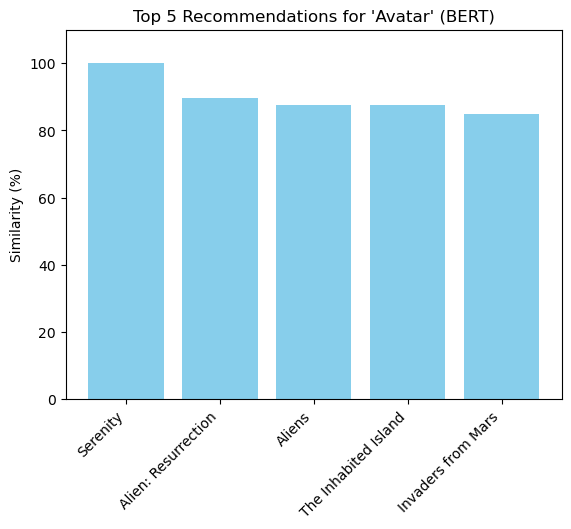

[('Serenity', np.float32(100.0)),
 ('Alien: Resurrection', np.float32(89.64739)),
 ('Aliens', np.float32(87.62249)),
 ('The Inhabited Island', np.float32(87.59813)),
 ('Invaders from Mars', np.float32(84.99248))]

In [71]:
recommend_movies_bert("Avatar")